In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
# Recuperar el mismo DataFrame
with open('dfe_guardado.pkl', 'rb') as e:
    dfe = pickle.load(e)
dfa = dfe.copy()

In [3]:
dfa.head(3000)

,torneo,semestre,ronda,fecha_torneo,equipo_local,equipo_visitante,goles_local,goles_visitante,resultado
0,2021,1,INICIAL,1,millonarios,envigado,1,0,LOCAL
1,2021,1,INICIAL,1,junior,medellin,1,0,LOCAL
2,2021,1,INICIAL,1,pasto,equidad,2,2,EMPATE
3,2021,1,INICIAL,1,nacional,santa fe,2,0,LOCAL
4,2021,1,INICIAL,1,cali,jaguares,1,0,LOCAL
...,...,...,...,...,...,...,...,...,...
2188,2025,2,CUADRANGULARES,1,medellin,america,1,1,EMPATE
2189,2025,2,CUADRANGULARES,1,fortaleza,santa fe,1,2,VISITANTE
2190,2025,2,CUADRANGULARES,1,bucaramanga,tolima,0,0,EMPATE
2191,2025,2,CUADRANGULARES,1,nacional,medellin,2,1,LOCAL


In [4]:
dfa.dtypes


torneo               int64
semestre             int64
ronda               object
fecha_torneo         int64
equipo_local        object
equipo_visitante    object
goles_local          int64
goles_visitante      int64
resultado           object
dtype: object

In [5]:
dfa = dfa.drop(['goles_local', 'goles_visitante'], axis=1)

In [6]:
# Crear un diccionario para guardar los codificadores (útil si luego quieres decodificar)
label_encoders = {}

# Codificar las columnas de texto
for column in ['ronda', 'equipo_local', 'equipo_visitante', 'resultado']:
    le = LabelEncoder()
    dfa[column] = le.fit_transform(dfa[column])
    label_encoders[column] = le


In [7]:
dfa.dtypes

torneo              int64
semestre            int64
ronda               int64
fecha_torneo        int64
equipo_local        int64
equipo_visitante    int64
resultado           int64
dtype: object

In [8]:
# Separar características y variable objetivo
X = dfa.drop('resultado', axis=1)
y = dfa['resultado']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# Entrenar modelo Random Forest con hiperparámetros ajustables
model = RandomForestClassifier(
    n_estimators=200,       # número de árboles
    max_depth=10,           # profundidad máxima
    min_samples_split=5,    # mínimo para dividir nodo
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

Exactitud del modelo: 0.41

Matriz de confusión:
[[ 30 117  23]
 [ 52 173  31]
 [ 26  77  20]]

Reporte de clasificación:
              precision    recall  f1-score   support

      EMPATE       0.28      0.18      0.22       170
       LOCAL       0.47      0.68      0.56       256
   VISITANTE       0.27      0.16      0.20       123

    accuracy                           0.41       549
   macro avg       0.34      0.34      0.32       549
weighted avg       0.37      0.41      0.37       549



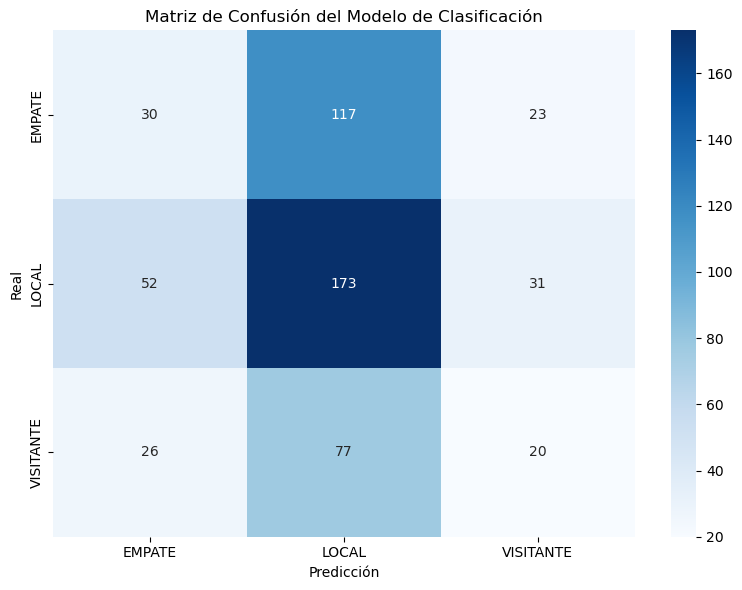

In [10]:
# Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoders['resultado'].classes_)

# Mostrar resultados
print(f"Exactitud del modelo: {accuracy:.2f}")
print("\nMatriz de confusión:")
print(conf_matrix)
print("\nReporte de clasificación:")
print(report)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['resultado'].classes_,
            yticklabels=label_encoders['resultado'].classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión del Modelo de Clasificación')
plt.tight_layout()


In [13]:
# Crear el partido nuevo
nuevo_partido = pd.DataFrame({
    'torneo': [2025],
    'semestre': [2],
    'ronda': ['FINAL'],
    'fecha_torneo': [1],
    'equipo_local': ['tolima'],
    'equipo_visitante': ['junior']
})


🔮 Probabilidades de resultado (partido nuevo):
0: 23.20%
1: 63.84%
2: 12.96%

✅ Resultado más probable: LOCAL


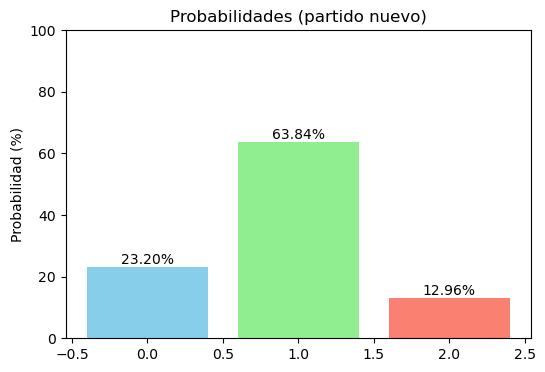

In [14]:
# 2) Codificar las mismas columnas categóricas que en entrenamiento
for column in ['ronda', 'equipo_local', 'equipo_visitante']:
    nuevo_partido[column] = label_encoders[column].transform(nuevo_partido[column])

# 3) Alinear columnas y orden EXACTO con X (usado en el fit)
#    Esto evita que falten columnas o cambie el orden respecto al entrenamiento
nuevo_partido = nuevo_partido[X.columns]

# 4) Predicción de clase y probabilidades para "nuevo_partido" (no X_test)
prediccion_codificada = model.predict(nuevo_partido)
resultado_final = label_encoders['resultado'].inverse_transform(prediccion_codificada)

proba = model.predict_proba(nuevo_partido)     # <--- usar nuevo_partido aquí
class_names = model.classes_                    # etiquetas internas del modelo

# 5) Mostrar probabilidades y clase más probable del partido nuevo
print("\n-----Porcentajes probables del Encuentro")
for i, cname in enumerate(class_names):
    print(f"{cname}: {proba[0][i]*100:.2f}%")

print("\n✅ Resultado más probable:", resultado_final[0])

# 6) Gráfico de barras
plt.figure(figsize=(6,4))
plt.bar(class_names, proba[0]*100, color=['skyblue','lightgreen','salmon'])
plt.title("Probabilidades (partido nuevo)")
plt.ylabel("Probabilidad (%)")
plt.ylim(0,100)
for i, p in enumerate(proba[0]*100):
    plt.text(i, p+1, f"{p:.2f}%", ha='center')
plt.show()

##### 